In [1]:
import numpy as np 
import pandas as pd 
import os
import pickle
import tensorflow as tf
import pandas as pd
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix 

In [3]:
csv_train_X = pd.read_csv('/kaggle/input/gstn-datasets/X_Train_Data_Input.csv')
csv_train_Y = pd.read_csv('/kaggle/input/gstn-datasets/Y_Train_Data_Target.csv')
csv_test_X = pd.read_csv('/kaggle/input/gstn-datasets/X_Test_Data_Input.csv')
csv_test_Y = pd.read_csv('/kaggle/input/gstn-datasets/Y_Test_Data_Target.csv') 

X_train = csv_train_X.to_numpy()[:, 1:].astype('float64')
Y_train = csv_train_Y.to_numpy()[:, 1:].astype('int32')
X_test = csv_test_X.to_numpy()[:, 1:].astype('float64')
Y_test = csv_test_Y.to_numpy()[:, 1:].astype('int32')



In [11]:
import pickle

# The Main Model 

class XGForce:
    # Model Constructor
    def __init__(self, model=None):              
        # The model that will be used when col 18 != 0
        self.model = model if model is not None else XGBClassifier(
            base_score=0.5, 
            booster='gbtree', 
            colsample_bylevel=1,
            colsample_bynode=1, 
            colsample_bytree=0.8,  # Reduce to avoid overfitting
            gamma=0,
            learning_rate=0.04,  # Reduce learning rate and increase n_estimators
            max_delta_step=0, 
            max_depth=10,  # Tune this parameter (3 to 10)
            min_child_weight=5,  # Increase to prevent overfitting
            n_estimators=200,  # Increase number of trees
            n_jobs=-1, 
            objective='binary:logistic', 
            random_state=0,
            reg_alpha=0.01,  # L1 regularization
            reg_lambda=1,  # L2 regularization
            scale_pos_weight=1, 
            subsample=0.7,  # Row subsampling
            verbosity=1  # Adjust verbosity
        )

        # Store the data it was last trained on, so as to allow the transformation of the Test Dataset w.r.t this Train Dataset when model.predict() is called.
        self.X_train = None
        
    # Min-Max Normalisation, and sets NaN values to 0 after normalising rest of the data!
    def normalize_array(self, train, test):
        # Step 1: Make a copy of the data to avoid modifying the original array
        normalized_train = np.copy(train)
        normalized_test = np.copy(test)
      
        # Step 2: Normalize each column
        for i in range(train.shape[1]): 
            col_train = train[:, i]
            col_test = test[:, i]
            # Get indices of non-NaN values to exclude NaNs from min-max calculation
            non_nan_train_mask = ~np.isnan(col_train)  
            non_nan_test_mask = ~np.isnan(col_test)  

            # Find min, max values
            col_min = np.min(col_train[non_nan_train_mask])
            col_max = np.max(col_train[non_nan_train_mask])
    
            # Step 3: Check if min and max are not equal to avoid division by zero
            if col_min != col_max:
                # Apply normalization formula to non-NaN values
                normalized_train[non_nan_train_mask, i] = 2 * (col_train[non_nan_train_mask] - col_min) / (col_max - col_min) - 1
                normalized_test[non_nan_test_mask, i] = 2 * (col_test[non_nan_test_mask] - col_min) / (col_max - col_min) - 1
    
        # Step 4: Replace NaN values with 0
        nan_train_mask = np.isnan(train)  # This identifies NaN values
        nan_test_mask = np.isnan(test)  # This identifies NaN values
        
        normalized_train[nan_train_mask] = 0
        normalized_test[nan_test_mask] = 0
        
        return normalized_train, normalized_test

    # Converts the train/test data to Ordinal form, after normalising and replacing NaN values.
    # This allows for more EVENLY spaced data, increasing gaps between extremely close points and hence improving accuracy of the model.
    def convert_to_ordinal(self, X_train, X_test):
        
        X_norm_train, X_norm_test = self.normalize_array(X_train, X_test)
        
        # Initialize arrays to hold converted values
        ordinal_X_train = np.zeros_like(X_norm_train)
        ordinal_X_test = np.zeros_like(X_norm_test)
        
        # Iterate through each column
        for col in range(X_train.shape[1]):
            # Get the current column from X_train and X_test
            train_col = X_train[:, col]
            test_col = X_test[:, col]
    
            # Step 1: Sort train_col and keep track of original indices
            sorted_idx = np.argsort(train_col)
            train_col_sorted = train_col[sorted_idx]
    
            # Step 2: Assign indices to sorted train_col values, ensuring duplicates get the same index
            unique_train_col, unique_indices = np.unique(train_col_sorted, return_inverse=True)
            ordinal_X_train[:, col][sorted_idx] = unique_indices  # Use unique indices for sorted train_col
    
            # Step 3: For each value in test_col, find where it lies between values in train_col
            for i, value in enumerate(test_col):
                # Find the insertion point in sorted train_col
                idx = np.searchsorted(train_col_sorted, value)
                
                if idx == 0:
                    if value < train_col_sorted[0]:
                    # If the value is smaller than all train_col values
                        ordinal_X_test[i, col] = unique_indices[0] - 1
                    else:
                        ordinal_X_test[i, col] = unique_indices[0]
                elif idx == len(train_col_sorted):
                    if value > train_col_sorted[-1]:
                    # If the value is larger than all train_col values
                        ordinal_X_test[i, col] = unique_indices[-1] + 1
                    else:
                        ordinal_X_test[i, col] = unique_indices[-1]
    
                else:
                    # Find the two bounding points in train_col
                    A = train_col_sorted[idx]     # Just larger than value
                    B = train_col_sorted[idx - 1] # Just smaller than value
                    
                    # Corresponding unique indices
                    C = unique_indices[idx]      # Unique index of A
                    D = unique_indices[idx - 1]  # Unique index of B
                    
                    # Linear interpolation between C and D
                    ordinal_X_test[i, col] = D + (C - D) * (value - B) / (A - B)
    
        return ordinal_X_train, ordinal_X_test

    def fit(self, X, y):
        # Fit the model only on rows where column 18 is not 0
        X_train = X[X[:, 18] != 0]
        y_train = y[X[:, 18] != 0]
        
        self.X_train = X_train    # Store Training Data for later.
        
        # Apply the ordinal data manipulation to X_train. Convert_to_ordinal() takes train and test data together, to normalise test data w.r.t to train data, but test data is absent during model.fit() call.
        ordinal_X_train, _ = self.convert_to_ordinal(X_train, np.zeros(X_train.shape))

        self.model.fit(ordinal_X_train, y_train)
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])

        # Find rows having Col18 = 0 and set prediction as 0.
        col_18_is_0_mask = (X[:, 18] == 0)
        y_pred[col_18_is_0_mask] = 0

        # For rest of the rows, normalise this data using the earlier stored X_train data, and then use XGB Model for predicting the outputs.
        _, ordinal_data_18 = self.convert_to_ordinal(self.X_train, X[~col_18_is_0_mask])
        y_pred_18 = self.model.predict(ordinal_data_18)
        y_pred[~col_18_is_0_mask] = y_pred_18

        return np.reshape(y_pred, (-1, 1)).astype('int32')
    
    def predict_proba(self, X):
        # Similar to predict, but returns probabilities instead of class labels

        prob_predictions = np.zeros((X.shape[0], 2))

        # Find rows having Col18 = 0 and set probability prediction as [1, 0] -> 100% chance target 0, 0% chance target 1
        col_18_is_0_mask = (X[:, 18] == 0)
        prob_predictions[col_18_is_0_mask] = [1, 0]

        # For rest of the rows, normalise this data using the earlier stored X_train data, and then use XGB Model for predicting the output probabilities.
        _, ordinal_data_18 = self.convert_to_ordinal(self.X_train, X[~col_18_is_0_mask])
        prob_pred_18 = self.model.predict_proba(ordinal_data_18)
        prob_predictions[~col_18_is_0_mask] = prob_pred_18
    
        return np.array(prob_predictions).astype('float32')

    # Function for saving the model
    def save_model(self, filepath):
        """
        Save the entire class instance to a file using pickle.
        """
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)

    # Function for loading back the saved model.
    @staticmethod
    def load_model(filepath):
        """
        Load the class instance from a pickle file.
        """
        with open(filepath, 'rb') as file:
            return pickle.load(file)


In [7]:
## Code For Plotting Confusion Matrix

def show_confusion_matrix(y_pred_prob, Y_test):
    # Convert probabilities to 0 or 1 based on a 0.5 threshold
    Y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]
    
    # Generate the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [23]:

# Prompt for using existing or new test dataset
test_dataset_choice = input("Do you want to use existing Test Dataset (press 0) or provide a new one (press 1)? ")

# If the user chooses to provide a new dataset
if test_dataset_choice == '1':
    # Take input for the path to the new testing dataset
    test_X_path = input("Please Enter Path to Testing Dataset (X_test): ")
    test_Y_path = input("Please Enter Path to Testing Dataset (Y_test): ")
    
    csv_test_X = pd.read_csv(test_X_path)
    csv_test_Y = pd.read_csv(test_Y_path) 

    X_test = csv_test_X.to_numpy()[:, 1:].astype('float64')
    Y_test = csv_test_Y.to_numpy()[:, 1:].astype('int32')

else:
    # Default message if they use the existing test dataset
    
    csv_test_X = pd.read_csv('/kaggle/input/gstn-datasets/X_Test_Data_Input.csv')
    csv_test_Y = pd.read_csv('/kaggle/input/gstn-datasets/Y_Test_Data_Target.csv') 
    
    print("Using existing Test Dataset!")
    
    X_test = csv_test_X.to_numpy()[:, 1:].astype('float64')
    Y_test = csv_test_Y.to_numpy()[:, 1:].astype('int32')

# Prompt for training model again or loading a pre-existing model
model_choice = input("Do you want to train model again (press 0) or load a pre-existing model (press 1)? ")

# If the user chooses to load a pre-existing model
if model_choice == '1':
    # Take input for the path to the pre-trained model
    trained_model_path = input("Please Enter Path to Trained Model (Pickle file): ")

    ## Put PATH to Pickle File
    model = XGForce.load_model(trained_model_path)

    
    print("Model Loaded Succesfully")
else:
    
    csv_train_X = pd.read_csv('/kaggle/input/gstn-datasets/X_Train_Data_Input.csv')
    csv_train_Y = pd.read_csv('/kaggle/input/gstn-datasets/Y_Train_Data_Target.csv')

    X_train = csv_train_X.to_numpy()[:, 1:].astype('float64')
    Y_train = csv_train_Y.to_numpy()[:, 1:].astype('int32')

    # Default message if they choose to train the model again
    print("Training model again")
    
    ## CREATE MODEL AND START TRAINING ON TRAIN DATA
    model = XGForce()
    model.fit(X_train, Y_train)

## PREDICT ON TEST DATA

Y_pred_test = model.predict(X_test)
print("Accuracy on Test Dataset is: ", metrics.accuracy_score(Y_test, Y_pred_test))


## PREDICT ON TRAIN DATA

# Y_pred_train = model.predict(X_train)
# print("Accuracy on Train Dataset is: ", metrics.accuracy_score(Y_train, Y_pred_train))


## TO SAVE A MODEL

print("Saving Model:", exit = " ")
model.save_model('XGForce-Model.pkl')        ## Put PATH to Pickle File

print("Done")



**EVALUATION METRICS FROM HERE ONWARDS**

In [24]:

Y_pred_test = model.predict(X_test)
print("Accuracy on Test Dataset is: ", metrics.accuracy_score(Y_test, Y_pred_test))

Y_pred_train = model.predict(X_train)
print("Accuracy on Train Dataset is: ", metrics.accuracy_score(Y_train, Y_pred_train))


Accuracy on Test Dataset is:  0.9786673901082106
Accuracy on Train Dataset is:  0.9814935813422694


In [ ]:
# Compute confusion matrix

conf = metrics.confusion_matrix(Y_test, Y_pred_test)
print("Confusion Matrix:", conf)
precision = conf[1][1]/(conf[1][1]+conf[0][1])
recall = conf[1][1]/(conf[1][1]+conf[1][0])
F1_Score = (2*(precision*recall)/(precision+recall))
print("precision: ", precision)
print("recall: ", recall)
print("F1_Score: ", F1_Score)

AUC: 0.9949804376869945


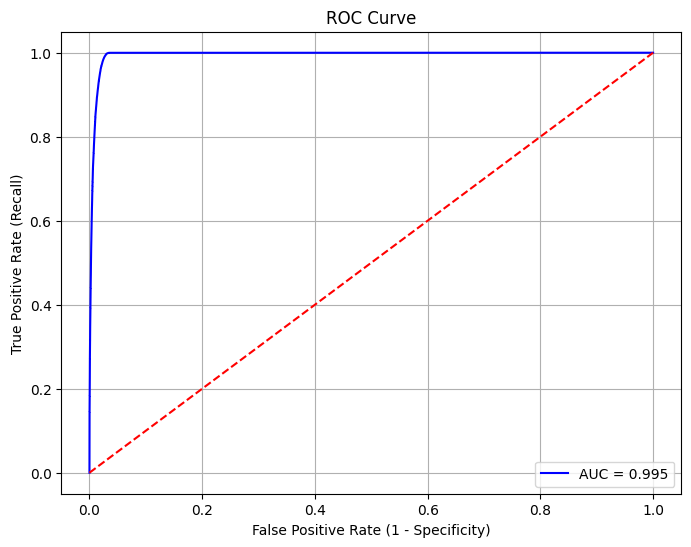

In [27]:
# Calculate AUC-ROC

from sklearn.metrics import roc_curve, roc_auc_score

Y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(Y_test, Y_prob)
print(f"AUC: {auc}")

# Generate ROC curve values: false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guess
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [28]:
# LOG LOSS

from sklearn.metrics import log_loss

Y_prob = model.predict_proba(X_test)

loss = log_loss(Y_test, Y_prob)

print("Log Loss of model on Test Data is: ", loss)

Log Loss of model on Test Data is:  0.048698078697287164


In [33]:
# Calculate Balanced Accuracy

def balanced_accuracy(y_true, y_pred):
    # Compute confusion matrix
    conf = confusion_matrix(y_true, y_pred)

    # Access confusion matrix values directly
    tn = conf[0, 0]  # True Negative
    fp = conf[0, 1]  # False Positive
    fn = conf[1, 0]  # False Negative
    tp = conf[1, 1]  # True Positive

    # True Positive Rate (Recall or Sensitivity)
    tpr = tp / (tp + fn)

    # True Negative Rate (Specificity)
    tnr = tn / (tn + fp)

    # Balanced Accuracy
    balanced_acc = (tpr + tnr) / 2

    return balanced_acc
    
balanced_acc = balanced_accuracy(Y_test, Y_pred_test)
print("Balanced Accuracy: ", balanced_acc)


Balanced Accuracy:  0.9612499915830773
